<a href="https://colab.research.google.com/github/vaibhav639/Airbnb-Bookings-Analysis/blob/main/NYC_Taxi_Trip_Time_Prediction_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

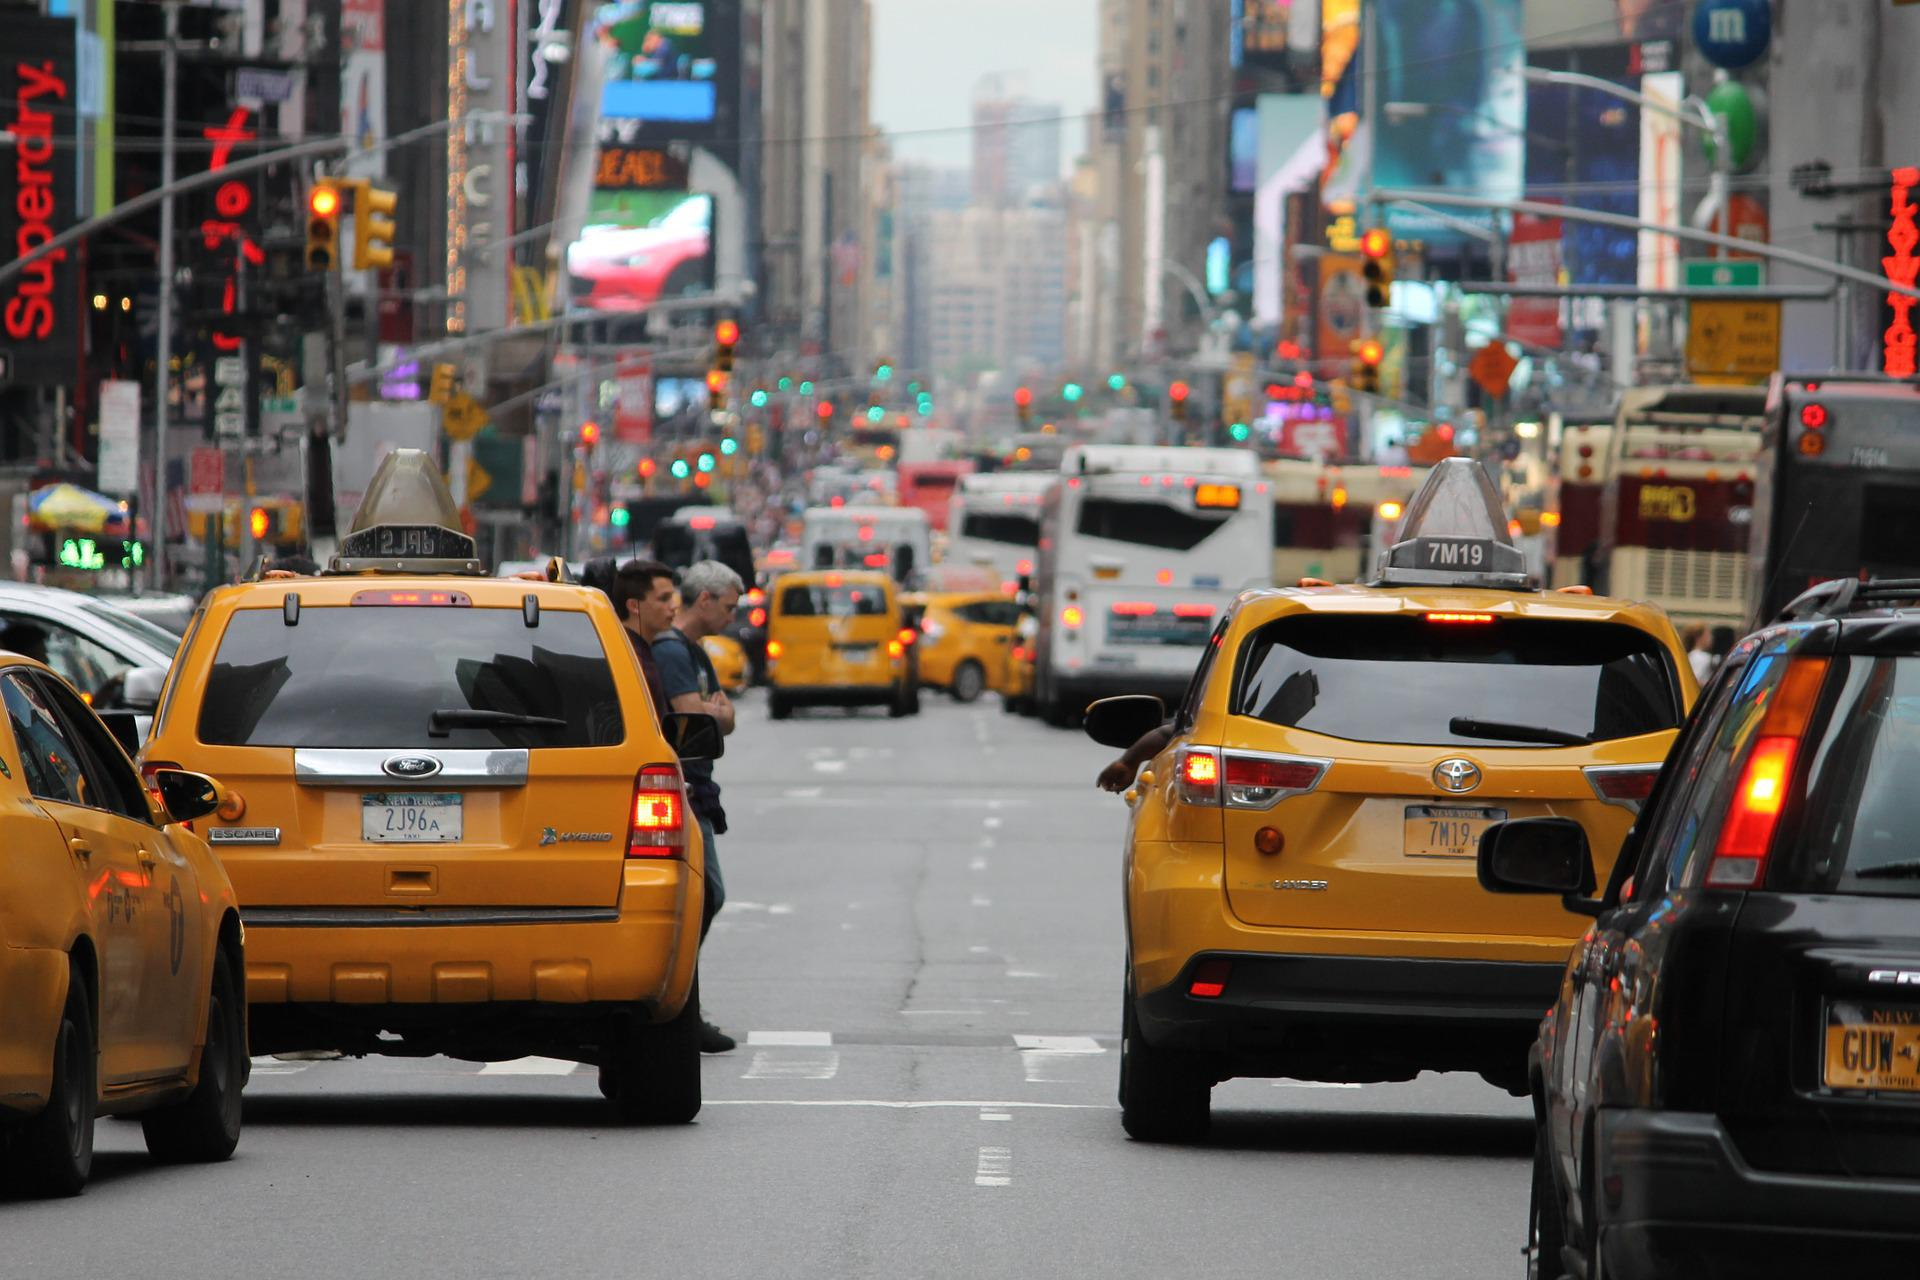

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [2]:
# Installing haversine for distance calculation
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Importing some important libraries 
import numpy as np
import pandas as pd
import math
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from datetime import datetime , timedelta
from math import radians, cos, sin, asin, sqrt

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from haversine import haversine
from sklearn.metrics.pairwise import haversine_distances
import statsmodels.formula.api as sm
from sklearn.feature_selection import RFE
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

**Mounting Google Drive**

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount =True)

Mounted at /content/drive


In [4]:
# Assigning the dataset to a variable using pandas
path = '/content/drive/MyDrive/csv files/NYC Taxi Data.csv'
data = pd.read_csv(path)

In [5]:
# Use this to mount your file path and comment out the above code
# path= ''
# data = pd.read_csv(path)

In [6]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [8]:
# Checking the overall information of our dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Checking for NaN and null data

In [9]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Luckily there are no NaN or null values in our dataset.

In [10]:
# Converting pickup and dropoff time to DateTime format.
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

##  **New FeaturesCreating**



In [11]:
data['pickup_weekday']=data['pickup_datetime'].dt.day_name()
data['dropoff_weekday']=data['dropoff_datetime'].dt.day_name()
data['pickup_weekday_num']=data['pickup_datetime'].dt.weekday
data['pickup_hour']=data['pickup_datetime'].dt.hour
data['dropoff_hour']=data['dropoff_datetime'].dt.hour
data['month']=data['pickup_datetime'].dt.month

Here we added some new features for our ease of processing.



*   pickup_weekday: This will contain the day on which ride was taken.
*   dropoff_weekday: This will contain the day on which ride was ended.
*   pickup_hour: time at which ride was started.
*   dropoff_hour: time at which ride was stoped.
*   month: month of the ride
*   pickup_weekday_num: number of the day on which ride was taken, taking Monday as 0.





In [12]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,dropoff_hour,month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,17,17,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,0,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,11,12,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,2,19,19,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,5,13,13,3


In [13]:
# Calculate distance from given latitude and longitude
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [14]:
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

In [15]:
data['speed'] = (data.distance/(data.trip_duration/3600))

## **Univariate Analysis**

### **Number of Passengers Per Cab**
#### This is done to check what are the minimum and maximum number of passengers travel per Taxi, and to check whether there are any outliers in our dataset.

In [16]:
data.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

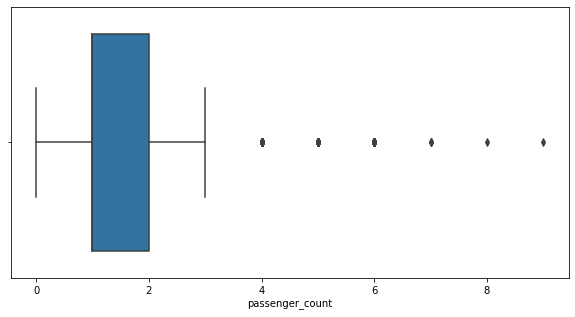

In [17]:
# Ploting passenger count using sns box plot.
plt.figure(figsize = (10,5))
sns.boxplot(data.passenger_count)
plt.show()


**Observation**

*   From the above Box Plot we can clearly notice there are some outliers in our dataset. It shows number of passengers per taxi is more than 7.
*   In most of the trips passenger number is between 1 or 2.

*   Minimum number of passengers per taxi is 0.

The minimum number is 0, it looks little concerning as a trip can not be done without a passenger. Lets check passenger count distribution using <code> .describe() </code> 









In [18]:
#checking the overall statistics of the passenger count using .describe()
data.passenger_count.describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

From above data we can see that Mean, Median and Mode are approximately equal to 1. So, we can replace 0 with 1 in passenger count data. Also we will remove the outliers in data which says passenger count is 7 or greater than 7, because it seems impossible to fit 7 passengers in a Taxi.

In [19]:
data['passenger_count'] = data.passenger_count.map(lambda x: 1 if x == 0 else x)
data = data[data.passenger_count <= 6]
data.passenger_count.value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

**Plotting Graph Between Passenger count Vs. Number of Trips**

From below Graphs we can observe that most of the trips were taken by 1 passenger.

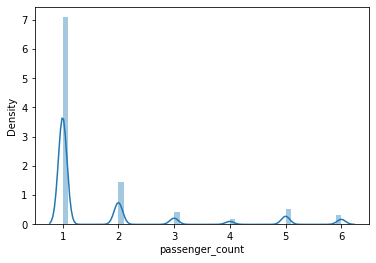

In [20]:
sns.distplot(data.passenger_count)
plt.show()

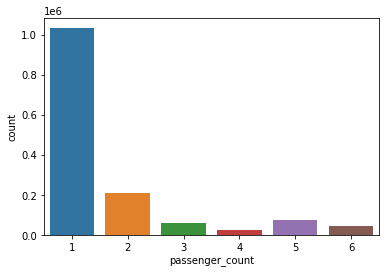

In [21]:
sns.countplot(data.passenger_count)
plt.show()

Most of the rides were done by single passenger.

## **Trip Duration**

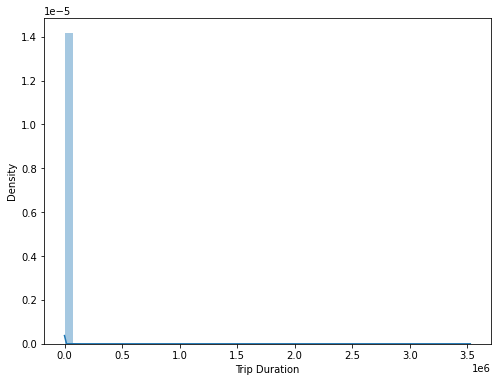

In [22]:
plt.figure(figsize = (8,6))
sns.distplot(data['trip_duration'])
plt.xlabel('Trip Duration')
plt.show()

From above graph we can see that it is Right skewed, lets apply log transformation to normalize it.

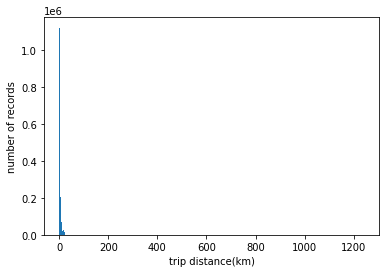

In [23]:

plt.hist(data['distance'].values, bins=300)
plt.xlabel('trip distance(km)')
plt.ylabel('number of records')

plt.show()

Trip distance is also right skewed.

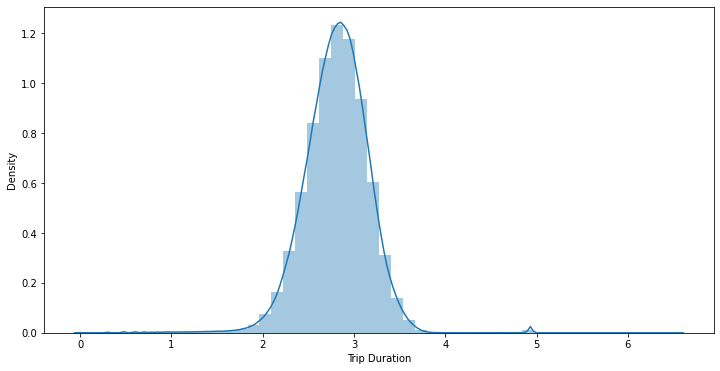

In [24]:
plt.figure(figsize = (12,6))
sns.distplot(np.log10(data['trip_duration']))
plt.xlabel('Trip Duration')
plt.show()

We can spot an outlier near 5 in the above plot.

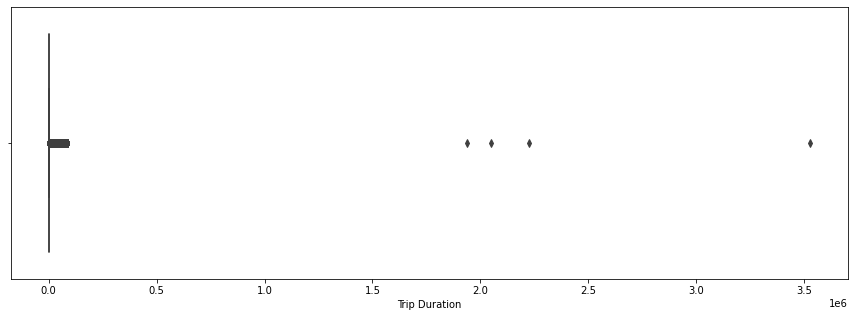

In [25]:
plt.figure(figsize = (15,5))
sns.boxplot(data.trip_duration)
plt.xlabel('Trip Duration')
plt.show()